In [27]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from scipy.spatial import procrustes
from scipy.stats import spearmanr
from tqdm import tqdm

In [7]:
DATA_DIR = '../../datasets/NNN/'
raster_data = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))

In [11]:
metric = 'correlation'
roi = 'MF1_8_F'
roi_data = raster_data[raster_data['roi']==roi]
stacked = np.stack(roi_data['img_psth'])  # (units, time, images)

In [12]:
img_sets = {'all images': np.arange(1000,1072), 
           'all faces': np.arange(1000,1024),
           'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
           'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
           'all nonfaces': np.arange(1025,1072),
           'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)])),
           'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
           'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           }

# --- compute averaged time×image and RDMs per set ---
avg_by_set, rdm_by_set = {}, {}
for name, idx in tqdm(img_sets.items()):
    sub = stacked[:, :, idx]
    avg = np.nanmean(sub, axis=0)         # (time, n_images_in_set)
    avg_by_set[name] = avg
    rdm_by_set[name] = squareform(pdist(avg, metric=metric))  # (time, time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.19it/s]


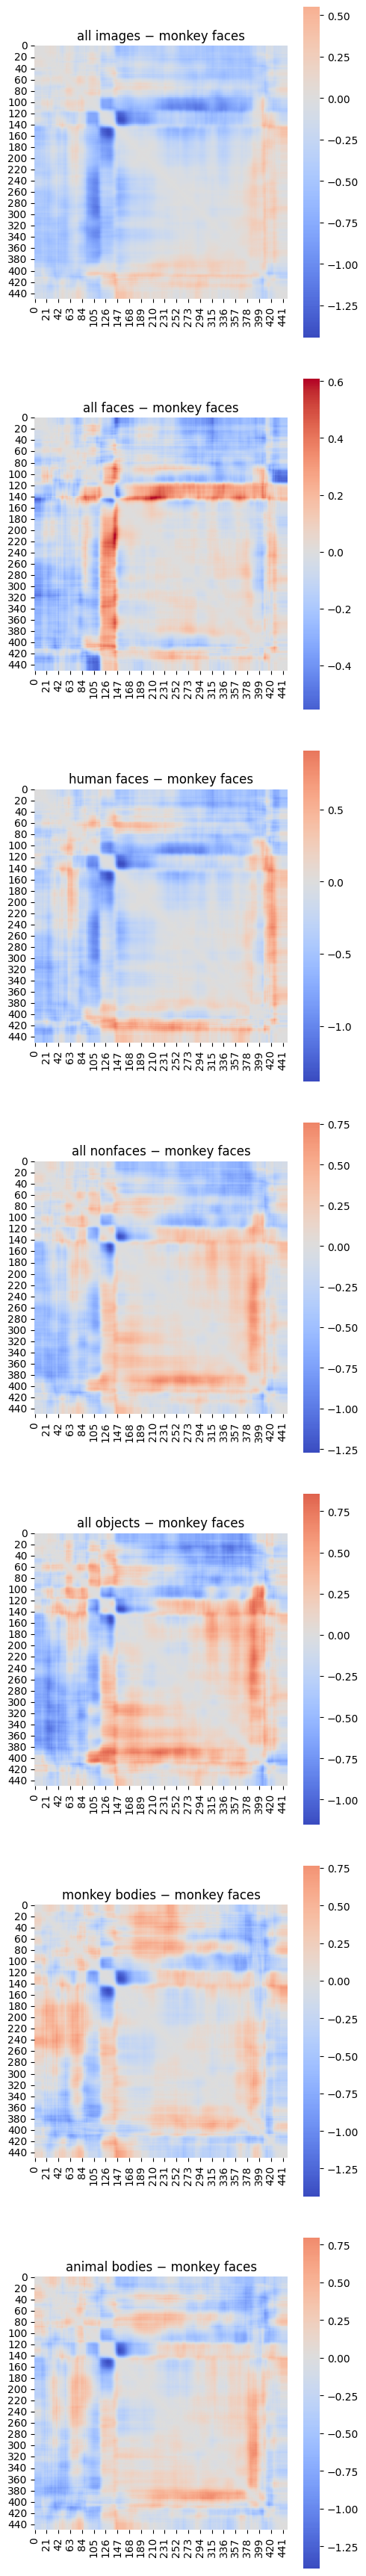

In [21]:
# --- RDM difference heatmaps vs first (reference) set ---
ref_name = 'monkey faces' # next(iter(img_sets))
ref_rdm = rdm_by_set[ref_name]

fig, axes = plt.subplots(len(img_sets)-1, 1, figsize=(5, 5*(len(img_sets)-1)), squeeze=False)
axes = axes.ravel()
for ax, (name, rdm) in zip(axes, [(k,v) for k,v in rdm_by_set.items() if k != ref_name]):
    diff = rdm - ref_rdm
    sns.heatmap(diff, cmap=sns.color_palette('coolwarm', as_cmap=True), center=0, ax=ax, square=True, cbar=True)
    ax.set_title(f"{name} − {ref_name}")
plt.tight_layout(); 
plt.show()

In [22]:
# --- Shared MDS space (align all sets to reference via Procrustes) ---
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=0)
coords_ref = mds.fit_transform(ref_rdm)  # reference embedding

# helper: light→dark colormap for a given base color
def fade_cmap(base_color):
    r,g,b,_ = plt.matplotlib.colors.to_rgba(base_color)
    return LinearSegmentedColormap.from_list("", [(1,1,1),(r,g,b)], N=256)

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


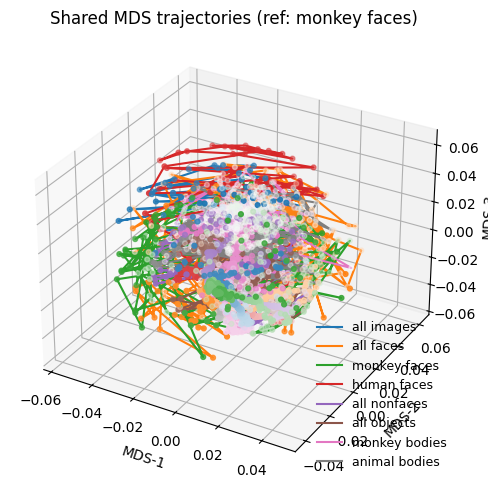

In [30]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, (name, rdm) in enumerate(rdm_by_set.items()):
    # embed each set; initialize with ref for stability, then Procrustes-align to ref
    coords = MDS(n_components=3, dissimilarity='precomputed', random_state=0,
                 n_init=1, max_iter=300, eps=1e-3, metric=True, verbose=0).fit_transform(rdm)
    A, B, _ = procrustes(coords_ref, coords)  # B aligned to A (ref)

    T = B.shape[0]
    ts = np.arange(T)
    cmap = fade_cmap(colors[i % len(colors)])

    # trajectory line and time-faded scatter
    ax.plot(B[:,0], B[:,1], B[:,2], color=colors[i % len(colors)], linewidth=1.5, label=name)
    sc = ax.scatter(B[:,0], B[:,1], B[:,2], c=ts, cmap=cmap, s=12)

ax.set_title(f"Shared MDS trajectories (ref: {ref_name})")
ax.set_xlabel("MDS-1"); ax.set_ylabel("MDS-2"); ax.set_zlabel("MDS-3")
ax.legend(frameon=False, fontsize=9)
plt.tight_layout(); plt.show()

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


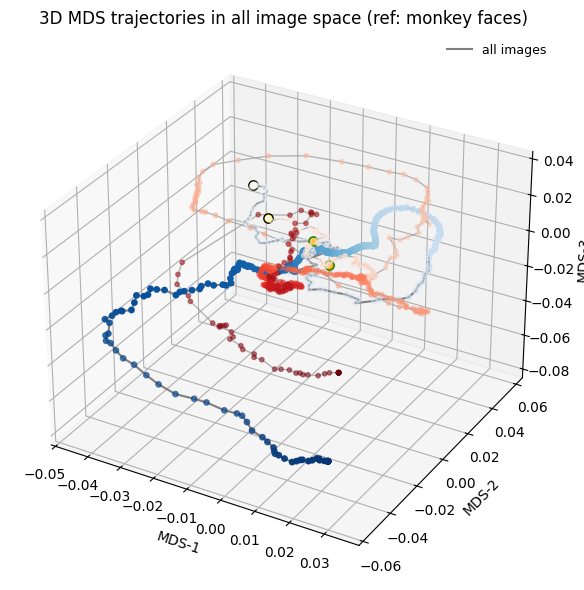

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


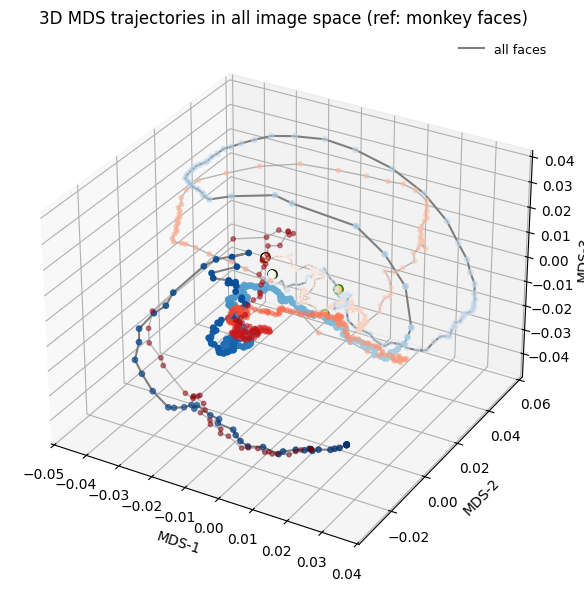

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


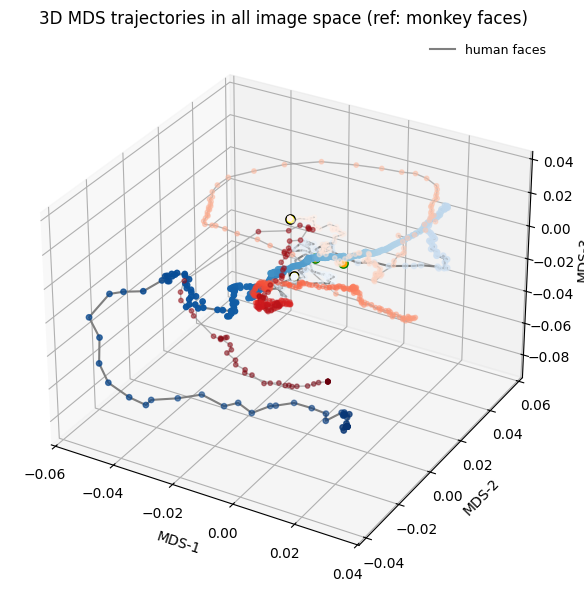

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


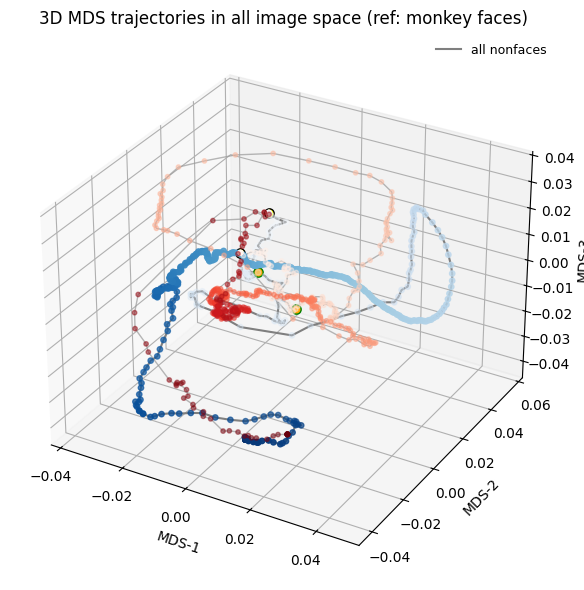

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


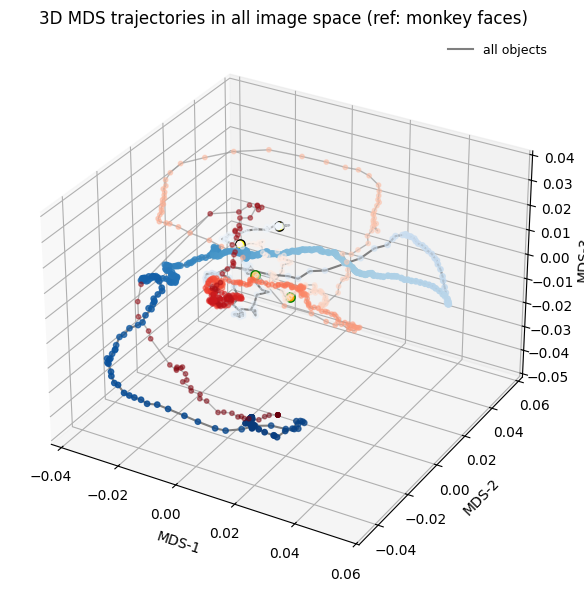

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


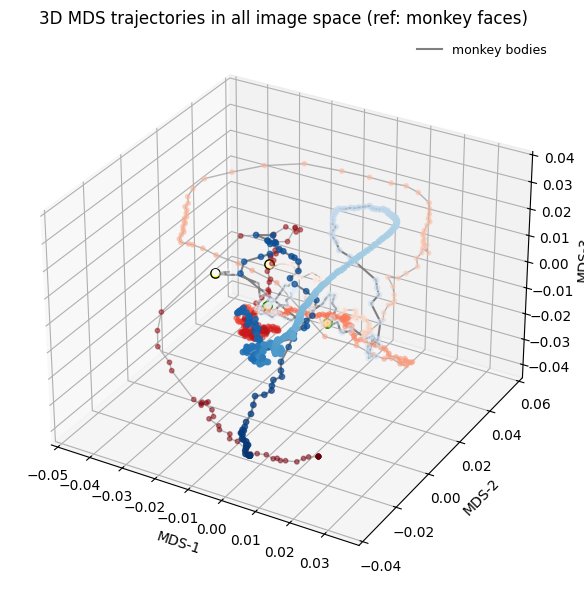

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


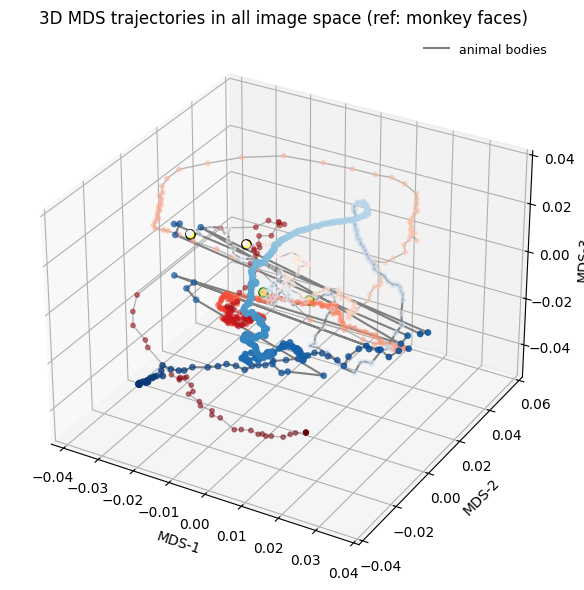

In [53]:
MDS_SPACE = 'all images'
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=0)
coords_ref = mds.fit_transform(rdm_by_set[MDS_SPACE])
T = coords_ref.shape[0]
ts = np.arange(T)

# --- 3D trajectories (aligned to reference) ---
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ref_c = (0.6, 0.6, 0.6)

ref_rdm = rdm_by_set[ref_name]

for i, (name, rdm) in enumerate(rdm_by_set.items()):
    if name == ref_name:
        continue
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    coords = mds.fit_transform(rdm)
    A, Bi, _ = procrustes(coords_ref, coords)  # align to reference

    # now project some other 
    coords = mds.fit_transform(ref_rdm)
    A, Bj, _ = procrustes(coords_ref, coords)  # align to reference

    # plot reference (red)
    ax.plot(Bj[:, 0], Bj[:, 1], Bj[:, 2],
            color=ref_c, linewidth=1.0, alpha=0.7)
    ax.scatter(Bj[:, 0], Bj[:, 1], Bj[:, 2],
               c=ts, cmap='Reds', s=10, alpha=0.5)

    # plot aligned target
    ax.plot(Bi[:, 0], Bi[:, 1], Bi[:, 2],
            color=base, linewidth=1.5, label=name)
    sc = ax.scatter(Bi[:, 0], Bi[:, 1], Bi[:, 2],
                    c=ts, cmap='Blues', s=15)

    # indicate start time
    t0 = 0; dot_size = 45; dot_color = 'yellow'; 
    ax.scatter(Bi[t0,0], Bi[t0,1], Bi[t0,2],
               s=dot_size, c=dot_color, edgecolor="black")
    ax.scatter(Bj[t0,0], Bj[t0,1], Bj[t0,2],
               s=dot_size, c=dot_color, edgecolor="black")

    # indicate image onset
    t0 = 49; dot_size = 45; dot_color = 'orange'; edge_color = 'green';
    ax.scatter(Bi[t0,0], Bi[t0,1], Bi[t0,2],
               s=dot_size, c=dot_color, edgecolor=edge_color)
    ax.scatter(Bj[t0,0], Bj[t0,1], Bj[t0,2],
               s=dot_size, c=dot_color, edgecolor=edge_color)

    ax.set_title(f"3D MDS trajectories in all image space (ref: {ref_name})")
    ax.set_xlabel("MDS-1"); ax.set_ylabel("MDS-2"); ax.set_zlabel("MDS-3")
    ax.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


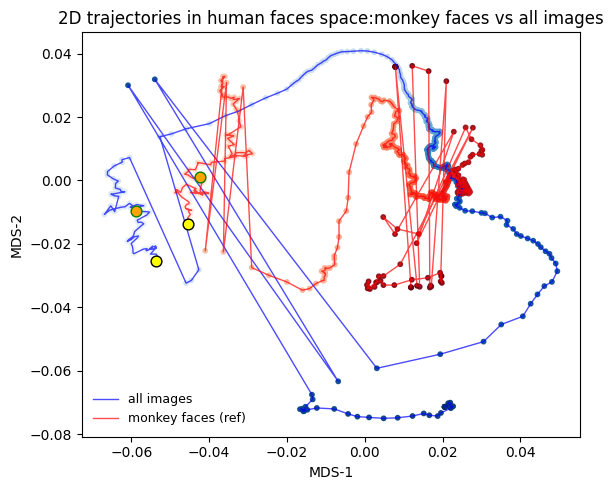

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


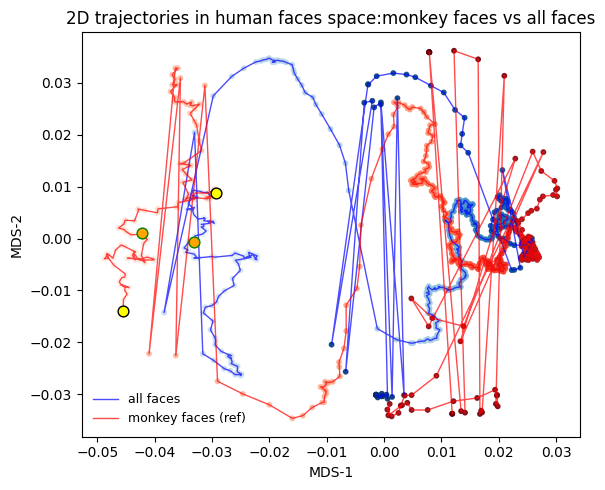

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


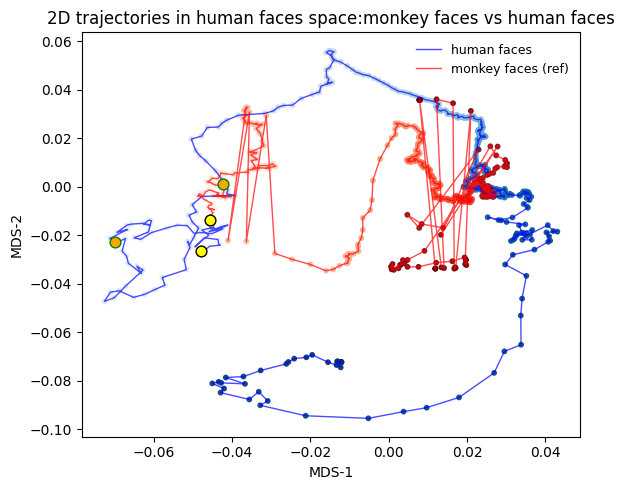

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


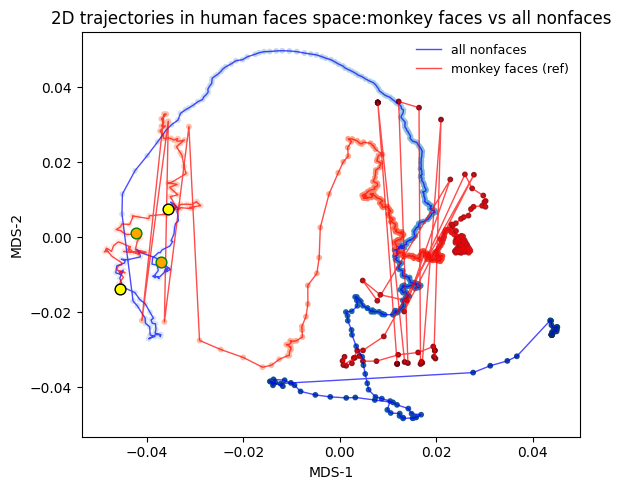

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


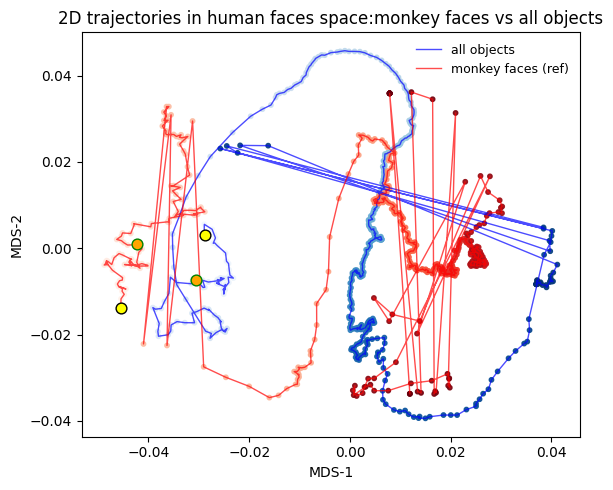

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


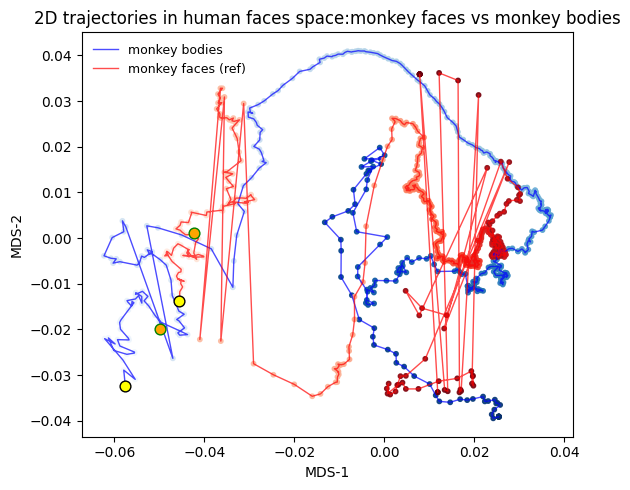

/Users/aim/miniconda3/envs/dynamics/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


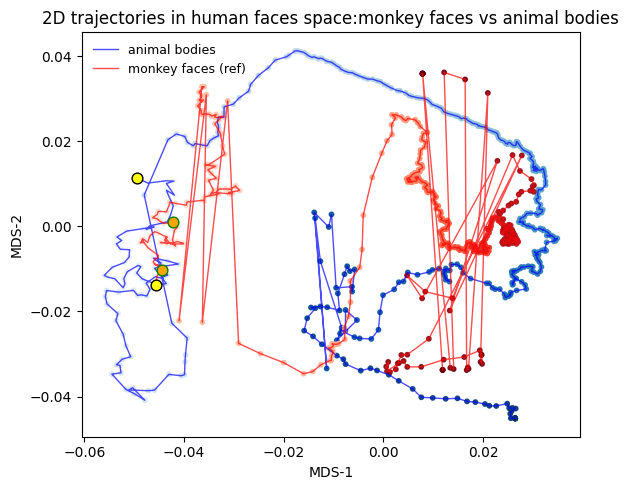

In [61]:
# use 2D MDS and 2D plots
MDS_SPACE = 'human faces'
ref_name = 'monkey faces'

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
coords_ref = mds.fit_transform(rdm_by_set[MDS_SPACE])

T = coords_ref.shape[0]
ts = np.arange(T)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ref_c = (0.6, 0.6, 0.6)

ref_rdm = rdm_by_set[ref_name]
# now project some other 
coords = mds.fit_transform(ref_rdm)
A, Bj, _ = procrustes(coords_ref, coords)  # align to reference

for i, (name, rdm) in enumerate(rdm_by_set.items()):
    if name == ref_name:
        continue

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    coords_i = mds.fit_transform(rdm)
    _, Bi, _ = procrustes(coords_ref, coords_i)  # align to reference
    base = colors[i % len(colors)]

    # target trajectory (colored, blue time colors)
    ax.plot(Bi[:, 0], Bi[:, 1], color='blue', linewidth=1, alpha=0.7, label=name)
    ax.scatter(Bi[:, 0], Bi[:, 1], c=ts, cmap='Blues', s=10, alpha=0.9)

    # reference trajectory (gray, red time colors)
    ax.plot(Bj[:, 0], Bj[:, 1], color='red', linewidth=1.0, alpha=0.7, label=f"{ref_name} (ref)")
    ax.scatter(Bj[:, 0], Bj[:, 1], c=ts, cmap='Reds', s=10, alpha=0.9)

    # markers at t=0 (yellow) and t=49 (orange/green)
    for t0, c, ec, sz in [(0, 'yellow', 'black', 60), (49, 'orange', 'green', 60)]:
        ax.scatter(Bj[t0, 0], Bj[t0, 1], s=sz, c=c, edgecolor=ec, zorder=5)
        ax.scatter(Bi[t0, 0], Bi[t0, 1], s=sz, c=c, edgecolor=ec, zorder=6)

    ax.set_title(f"2D trajectories in {MDS_SPACE} space:{ref_name} vs {name}")
    ax.set_xlabel("MDS-1"); ax.set_ylabel("MDS-2")
    ax.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

In [28]:
# compare each set to reference via RDM vector correlation (Spearman) and MSE
ref = rdm_by_set[ref_name]
tri = np.triu_indices_from(ref, k=1)
ref_vec = ref[tri]

results = {}
for name, R in rdm_by_set.items():
    if name == ref_name: 
        continue
    vec = R[tri]
    corr = spearmanr(ref_vec, vec, nan_policy='omit').correlation
    mse  = np.nanmean((R - ref)**2)
    results[name] = {'spearman_r': corr, 'mse': mse}

# sorted summary (highest similarity first)
summary = sorted(results.items(), key=lambda kv: (-np.nan_to_num(kv[1]['spearman_r'], nan=-1), kv[1]['mse']))
for name, stats_ in summary:
    print(f"{name:15s}  r={stats_['spearman_r']:.3f}   mse={stats_['mse']:.4f}")


all faces        r=0.930   mse=0.0240
monkey bodies    r=0.797   mse=0.0864
animal bodies    r=0.780   mse=0.0776
all images       r=0.738   mse=0.1186
human faces      r=0.729   mse=0.1133
all nonfaces     r=0.687   mse=0.0833
all objects      r=0.605   mse=0.1114
